# Goal
Explore neural network regression of pixel sum regression when dealing with noisy data. Formulate expectations of predictions (after training) with respect to the noise in the input.

In [4]:
import keras
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.keras.backend.set_floatx('float64')

# Regression of pixel sum
A network of one neuron fully connected to $N=n\times n$ pixels of an input image is easily capable to learn regression of the sum of all pixel values. This is accomplished when the bias is 0 and all weights are 1. Only the chosen floating-point accuracy of the network parameters cause some error:

32/32 [==============================] - 0s 680us/step
Rel. error:  7.918841596567897e-08
Comparison of expl. values:  27.23093 27.23093241781294


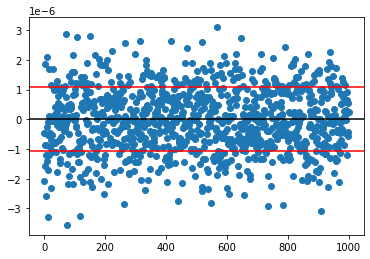

In [4]:
W = 7 # side length (width) of images
N = 1000 # no. samples

data = np.random.rand(N,W,W)
truth = np.sum(data, axis=(1,2)) # sum of all pixels in a image for all samples
truth_range = np.max(truth) - np.min(truth)

model = keras.Sequential([keras.Input(shape=(W,W)), # Shallow network
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)]) # no bias

model.get_weights()
model.set_weights([np.ones((W*W,1))]) # Set all weights to 1.

pred = model.predict(data).flatten() # predict pixel sum
res = pred - truth # residuals
std = np.std(res)

plt.plot(res, 'o');
plt.axhline(0, c='k');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');

print('Rel. error: ', std / truth_range)
print('Comparison of expl. values: ', pred[0], truth[0]) # error only by "rounding", i.e. cutoff. If we use tf.keras.backend.set_floatx('float64') we can decrease this error.

This was for a fixed network and no training. Let's initialize the weights randomly and train a network on MSE to learn the pixel sum regression itself.

32/32 [==============================] - 0s 500us/step
Rel. error:  1.220189557526595e-07


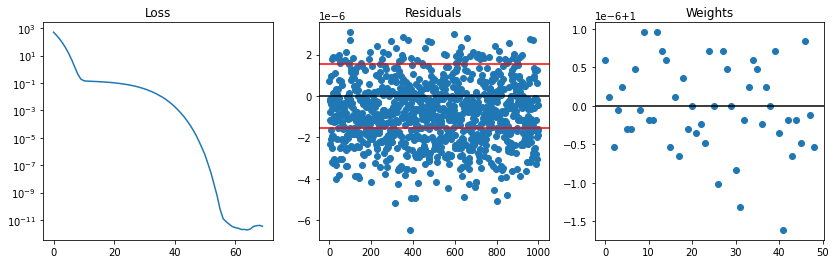

In [3]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(data, truth, epochs=70, verbose=False, batch_size=4)

pred = model.predict(data).flatten()
res = pred - truth
std = np.std(res)
print("Rel. error: ", std / truth_range);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_yscale('log');
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

After only a couple of epochs our training converges (note the loss plot is in log scale). We see that the network correctly finds weights in the neighborhood of $1$.<br>

**Note:** After epoch 80 something weird happens with training using MSE, the loss goes up again (maybe we are starting to overfit here). Therefore I stopped training after 60 epochs.

# Regression of noisy pixel sum
Now, let's add some noise to each pixel value.

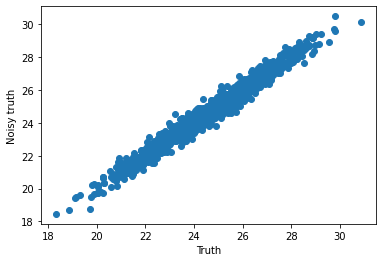

In [4]:
std = 0.05
noisy_data = data + np.random.normal(0,std,size=data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

We denote the standard deviation of the $i$-th pixel value as $\sigma_i$ for $N=n\times n$ total pixel values in an image. In this case $\sigma_{tot}=\sqrt{\sum_{i=1}^N{\sigma_i^2}}$, by error propagation. Here we set $\sigma=0.05, N=49$, thus $\sigma_{tot}=\sqrt{49\times 0.05^2}=0.35$. Next, we train our network using the noisy data and the (not noisy) truth. Afterwards, we are interested in the the noise of the predictions, i.e. **standard deviation of the residuals**.

32/32 [==============================] - 0s 565us/step
Standard deviation of residuals: 0.3623756348742376


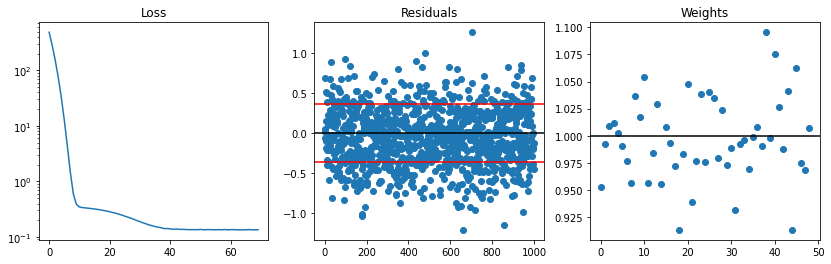

In [5]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=70, verbose=False, batch_size=4)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[0].set_yscale('log');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

We see that the **error in the predictions is close to the noise in the data**. If we increase the noise in the data, the noise in the predictions scales linearly with it. This is not very surprising in hindsight but still a point worse emphasizing:
* (Random, "structureless") noise in the input will also appear in the predictions.

# Regression of increasingly noisy pixel sums
Let's see how the network performs for input data for which the *noise scales linearly with its pixel sum*. This is a similar situation we face for Calorimeter data in which the "noise" in the data (due to encoding and due to Poissonian statistic for number of ionized particle in active detector material) also scales with the energy sum in the detector.

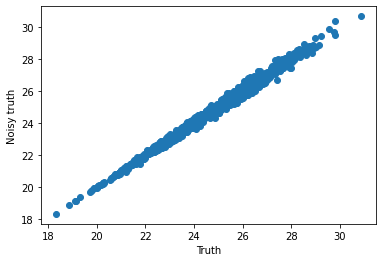

In [6]:
std = (truth-np.min(truth)) / (np.max(truth) - np.min(truth)) * 0.05 # scale standard deviation from 0(min)..0.05(max)
noisy_data = data + np.random.normal(0,std[:,None,None], data.shape) # add (Gaussian) noise to data
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

Let's train a network on this type of input data.

32/32 [==============================] - 0s 541us/step
Standard deviation of residuals (predictions): 0.17413746469365388
Standard deviation of residuals (noisy truth): 0.1774657373197544


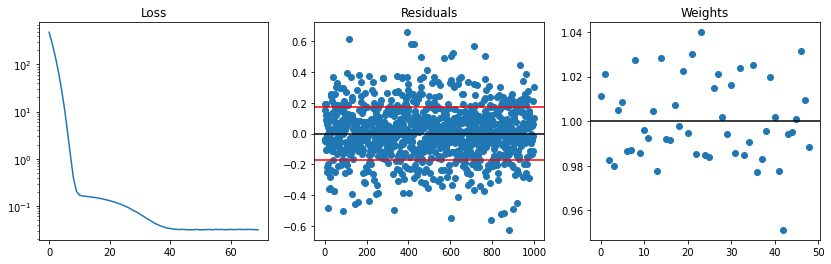

In [8]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=70, verbose=False, batch_size=4)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
ids = truth.argsort()
print("Standard deviation of residuals (predictions):", std);
print("Standard deviation of residuals (noisy truth):", np.std(noisy_truth[ids] - truth[ids]));

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[0].set_yscale('log');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

As the overall noise in the input data is less than the overall noise in the previous case, the **noise in the predictions is also less**, as expected. Now, we can compare the residuals of the predicted data vs. the residuals of the input data (both to the true pixel sum value). As we see those agree pretty well, i.e. we directly see what we observed previously: **The noise in the input is also present in the predictions** is also true for non-constant noise.

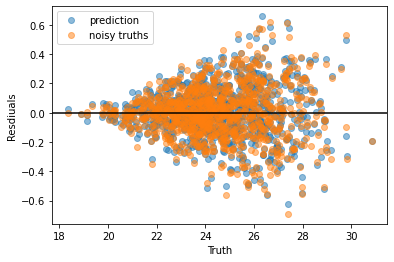

In [9]:
sorted_res = pred[ids] - truth[ids]
plt.plot(truth[truth.argsort()], sorted_res, 'o', alpha=0.5, label='prediction');
plt.plot(truth[ids], noisy_truth[ids] - truth[ids], 'o', alpha=0.5, label='noisy truths');

plt.axhline(0, c='k');
plt.ylabel('Resdiuals');
plt.xlabel('Truth');
plt.legend();

**Result**: For any shallow (or deep) network which maps an input image to a single (fully connected) output neuron we are able to learn a function which regresses the pixel sum. And for this the noise which is present in the input will also be present in the output, i.e. the std of the residuals $\hat{y}-y$ and $\tilde{y}-y$ are approximately the same, where $y$ is the truth, $\hat{y}$ is the prediction and $\tilde{y}$ is data with (random) noise applied to it. We only tested for "structureless", purely random noise. If there is some pattern to the noise, the network might be able to learn this and might actually perform better than this.

# Calorimeter data
As mentioned before, for Calorimeter data we have a similar situation as in the case for *increasingly noisy pixel sums* in the input data. Here is what we get if we plot pixel sums as function of the true sums (left) and sum of encoded pixel values vs. true sums (right). The two representations are connected a encoding-decoding function. Thus, in order to obtain the linearly increasing noisy representation from the given Calorimeter data (which we assume will be in **encoded** form) we first need to apply the decoding function before we can perform pixel sum regression.<br>

<table>
    <tr>
        <td><img src="mod2.png" width="400"></td>
        <td><img src="mod1.png" width="400"></td>
        <td><img src="mod3.png" width="400"></td>
    </tr>
</table>

Thus, if we can train a network to learn the decoding function we know from the study of *increasingly noisy pixel sums* that we can regress from this **decoded** representation the pixel sum with the same amount of noise present in the decoded data. In the following we show:
1. What does the encoding and decoding functions do?
1. How can we model Calorimeter data? How much noise is in it?
2. Train a network to learn the decoding function, i.e. the "decoder".
3. Concatenate the "decoder" with a "regressor". How does it perform?
4. Train a network to learn decoding and regressing at once. How does it perform?

# 1. Encoding and decoding functions
Our function of interest maps values from a large integer range $[0...\sim230000]$ into a much smaller one $[0..127]$. It does so by mapping the first few values 1-to-1 and the larger ones with exponentially increasing gaps in between to the following codes.

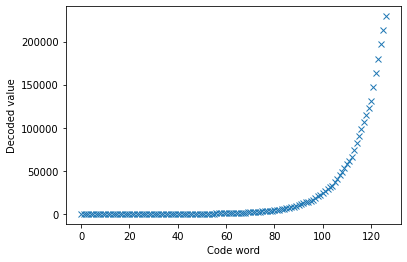

In [8]:
from bitstring import BitArray
from functools import lru_cache

exp_bits = 4
man_bits = 3
max_TCval = (2**man_bits - 1) * 2**(2**exp_bits - 1)
max_TCcode = 2**(man_bits+exp_bits) - 1

@np.vectorize
@lru_cache(128)
def decode(code):
    code = int(code)
    assert(code.bit_length() <= man_bits+exp_bits)
    assert(code >= 0)
    
    bits = BitArray(uint=code, length=man_bits+exp_bits)
    ebits = bits[:exp_bits]
    mbits = bits[exp_bits:]
    
    if ebits.uint == 0:
        return mbits.uint
    else:
        return (BitArray('0b1') + mbits).uint << (ebits.uint - 1)
    
@np.vectorize
@lru_cache(128)
def encode(val):
    assert(val >= 0)
    val = np.int32(val)
    bit_len = val.item().bit_length()
    if bit_len <= man_bits:
        return val # special case: return mantissa if value in this range
    if val >= max_TCval:
        return max_TCcode # clip overflow
    
    exp = bit_len - man_bits
    man = val >> exp - 1
    
    ebits = BitArray(uint=exp, length=exp_bits)
    mbits = BitArray(uint=man, length=man.item().bit_length())[1:]
    
    return (ebits+mbits).uint

r = np.array(range(max_TCcode))
plt.plot(decode(r), 'x')
plt.xlabel('Code word')
plt.ylabel('Decoded value');

# 2. Modeling Calorimeter data
For an EM shower caused by a single particle we expect that only a few pixels in the whole Calorimeter are *activated* while the majority of pixels are 0. Let's consider for simplicity a MIP shower, which is very concise. From the perspective of a single Calorimeter layer, we see a bright center spot for which the neighboring pixel values are also activated but whose intensity decreases quickly with distance from the center. However, for pixel sums the spatial distribution of these pixel in a layer does not really matter, only the distribution of pixel values matters. We can approximately model this behavior by a Beta-function with large probability for occurance of small values and low probability for larger values. Furthermore, we model **modules** here as images of $7\times 7$ pixel values. For these we know that the majority will be 0, thus additionally, we choose about 98% of those modules to be completely dark.

In [118]:
a,b = 0.03,2.4
N = 100_000
W = 7

r = np.zeros((N,W,W))
k = N // 50
r[:k] = np.random.beta(a,b,size=(k,W,W))
adcs = (r * max_TCval).astype(int)

codes = encode(adcs)
decodes = decode(codes)

code_sum = np.sum(codes, axis=(1,2))
adc_sum = np.sum(adcs, axis=(1,2))
decode_sum = np.sum(decodes, axis=(1,2))

code_range = np.max(codes) - np.min(codes)
decode_range = np.max(decodes) - np.min(decodes)

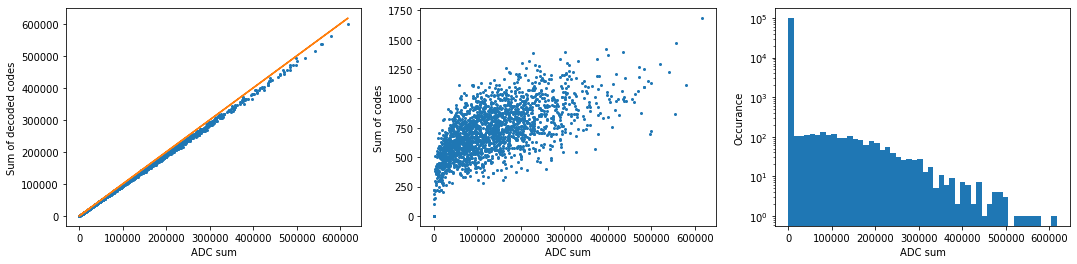

In [119]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].plot(adc_sum, decode_sum, 'o', markersize=2);
ax[0].plot(adc_sum, adc_sum);
ax[0].set_xlabel('ADC sum');
ax[0].set_ylabel('Sum of decoded codes');

ax[1].plot(adc_sum, code_sum, 'o', markersize=2);
ax[1].set_xlabel('ADC sum');
ax[1].set_ylabel('Sum of codes');

ax[2].hist(adc_sum, bins=50);
ax[2].set_xlabel('ADC sum');
ax[2].set_ylabel('Occurance');
ax[2].set_yscale('log');

This looks about right. Let's get an impression for the noise in this data by looking at the residuals of the sum decoded codes and true sums. And here we only need to look at the residuals for pixel sums that are non-zero, as for those who are zero, the residual will simply be zero as well (the encoding-decoding of 0 is still 0). As the decoded codes are strictly below the true pixel values due to the encoding function our residuals are always positive and seemingly Beta/Poissonian distributed.

Abs. std:  5022.143719736996
Rel. std:  0.02357902512646952


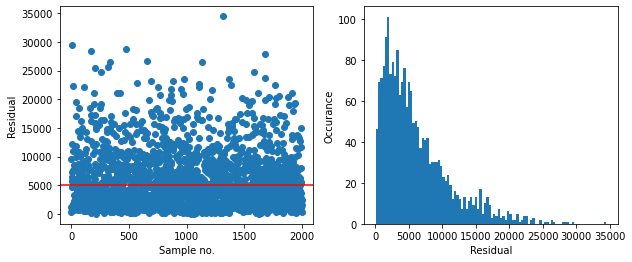

In [148]:
res = adc_sum[:k] - decode_sum[:k]
std = np.std(res)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(res,'o');
ax[0].axhline(std, c='red');
ax[0].set_ylabel('Residual');
ax[0].set_xlabel('Sample no.');

ax[1].hist(res, bins=100);
ax[1].set_ylabel('Occurance');
ax[1].set_xlabel('Residual');

print('Abs. std: ', std)
print('Rel. std: ', std/decode_range)

# 3. Learning the decoding function
Before we start training we need to rescale the codes and ADCs, s.t. our network parameters can quickly converge.

In [121]:
codes_normed = codes / code_range
decodes_normed = decodes / decode_range

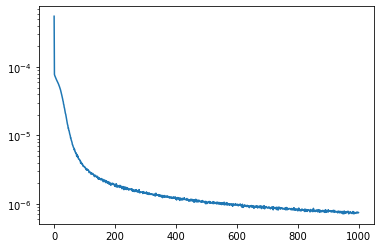

In [129]:
decoder = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(256, activation='sigmoid'),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(49, activation='linear'),
                          keras.layers.Reshape((7,7))
                         ])


decoder.compile(loss='mse', optimizer='adam')
hist = decoder.fit(codes_normed, decodes_normed, epochs=1000, verbose=False, batch_size=32)#, callbacks=[hist])
plt.plot(hist.history['loss'])
plt.yscale('log')

We can see that after 1000 epochs, the network is still learning. We could probably train for even longer to get better results. Let's take a look how the predictions compare to the true ADC sums.

3125/3125 [==============================] - 2s 623us/step
Abs. std:  9151.873696709115
Rel. std:  0.04296815700453123
Abs. (abs) std:  6847.725420441806
Rel. (abs) std:  0.03215015315336635


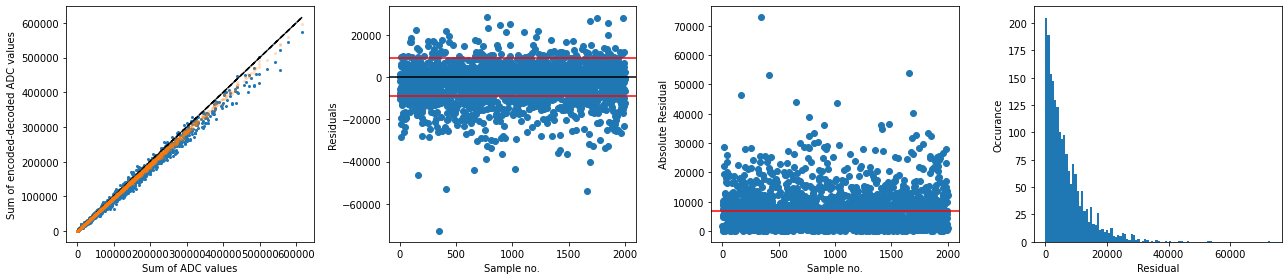

In [147]:
decoder_pred = decoder.predict(codes_normed)
pred_sum = np.sum(decoder_pred * decode_range, axis=(1,2))

fig, ax = plt.subplots(1,4, figsize=(18,4))

ax[0].plot(adc_sum, pred_sum, 'o', markersize=2);
ax[0].plot(adc_sum, adc_sum, '--', c='k');
ax[0].plot(adc_sum, decode_sum, 'o', markersize=2, alpha=0.2);
ax[0].set_xlabel('Sum of ADC values');
ax[0].set_ylabel('Sum of encoded-decoded ADC values');

res = (pred_sum - decode_sum)[:k]
std = np.std(res[:k]) # exclude all sums which equal to zero for fair comparison.

print('Abs. std: ', std)
print('Rel. std: ', std/decode_range)

ax[1].plot(res, 'o');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[1].set_ylabel('Residuals');
ax[1].set_xlabel('Sample no.');

res = np.abs((pred_sum - decode_sum)[:k]) # Let's look at the absolute residuals
std = np.std(res)

ax[2].plot(res,'o');
ax[2].axhline(std, c='red');
ax[2].set_ylabel('Absolute Residual');
ax[2].set_xlabel('Sample no.');

ax[3].hist(res, bins=100);
ax[3].set_ylabel('Occurance');
ax[3].set_xlabel('Residual');

plt.tight_layout();

print('Abs. (abs) std: ', std)
print('Rel. (abs) std: ', std/decode_range)

We see that our network is capable of learning the decoding function. In the limit of infinite training time we'd probably perform better.

# 4. Concatenate networks
Now, we concatenate the above trained *decoder* network with a subsequent *regressor* network.

Before we need do so, we need to create and train the *regressor*. We do this on the predictions of the regressor from above.

3125/3125 [==============================] - 2s 508us/step
Abs. std:  7732.838337341245
Rel. std:  0.036305768936585624
Abs. (abs) std:  6613.823263635415
Rel. (abs) std:  0.031051979715836345


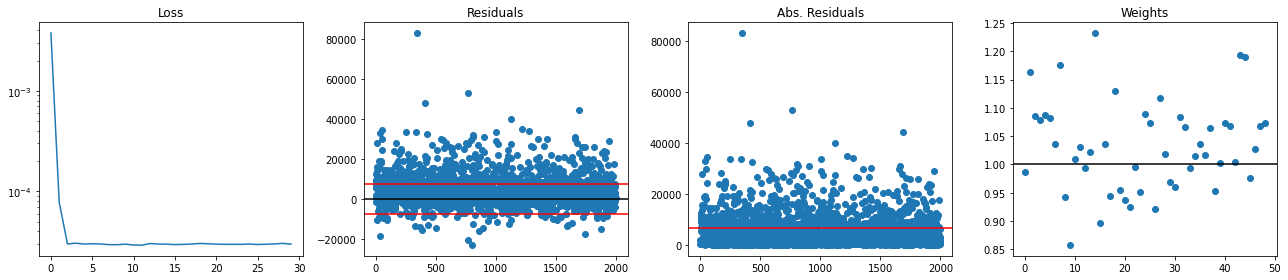

In [139]:
regressor = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

regressor.compile(loss='mse', optimizer='adam')

normed_decode_sum = decode_sum / decode_range

hist = regressor.fit(decoder_pred, normed_decode_sum, epochs=30, verbose=False, batch_size=4)

pred = regressor.predict(decodes_normed) * decode_range
res = (pred.flatten() - decode_sum)[:k]
std = np.std(res)

print("Abs. std: ", std);
print("Rel. std: ", std/decode_range);

fig, ax = plt.subplots(1,4, figsize=(18,4))

ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[0].set_yscale('log');

ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');

res = np.abs((pred.flatten() - decode_sum)[:k])
std = np.std(res)

print("Abs. (abs) std: ", std);
print("Rel. (abs) std: ", std/decode_range);

ax[2].plot(res, 'o');
ax[2].set_title('Abs. Residuals');
ax[2].axhline(std, c='red');

ax[3].plot(regressor.get_weights()[0].flatten(), 'o');
ax[3].axhline(1, c='k');
ax[3].set_title('Weights');

plt.tight_layout();

Now, concatenate the networks

3125/3125 [==============================] - 2s 636us/step
Abs. std:  7120.754639361693
Rel. std:  0.033432028617796414
Abs. (abs) std:  5057.781093757785
Rel. (abs) std:  0.023746343025830948


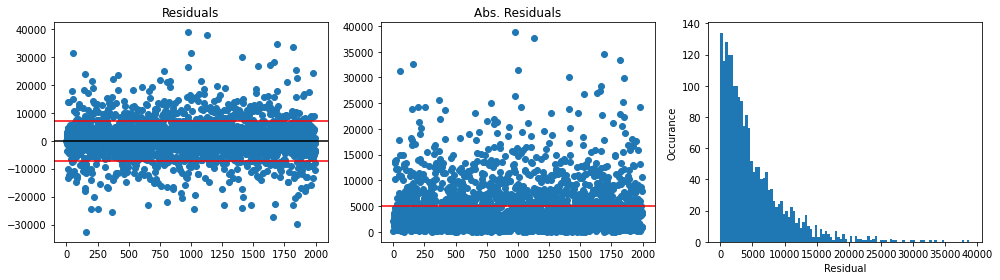

In [146]:
model = keras.Sequential([decoder, regressor])
pred = model.predict(codes_normed) * decode_range

res = (pred.flatten() - decode_sum)[:k]
std = np.std(res)

print("Abs. std: ", std);
print("Rel. std: ", std/decode_range);

fig, ax = plt.subplots(1,3, figsize=(14,4))

ax[0].plot(res, 'o');
ax[0].set_title('Residuals');
ax[0].axhline(0, c='k');
ax[0].axhline(std, c='red');
ax[0].axhline(-std, c='red');

res = np.abs((pred.flatten() - decode_sum)[:k])
std = np.std(res)

print("Abs. (abs) std: ", std);
print("Rel. (abs) std: ", std/decode_range);

ax[1].plot(res, 'o');
ax[1].set_title('Abs. Residuals');
ax[1].axhline(std, c='red');

ax[2].hist(res, bins=100);
ax[2].set_ylabel('Occurance');
ax[2].set_xlabel('Residual');

plt.tight_layout();

The resulting absolute std is surprisingly close to the noise in the data. Thus we can conclude that the concatenated network strategy works quite well.

# 5. Simultaneous decoding and regression
Let's see how a net trained on decoding and regression at once compares to this.

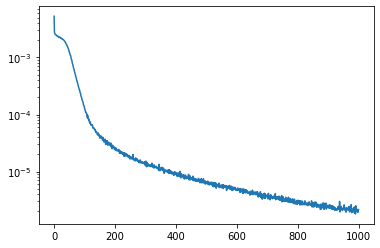

In [143]:
model2 = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(256, activation='sigmoid'),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(32, activation='sigmoid'),
                          keras.layers.Dense(1, activation='linear'),
                         ])

model2.compile(loss='mse', optimizer='adam')
hist = model2.fit(codes_normed, normed_decode_sum, epochs=1000, verbose=False, batch_size=32)#, callbacks=[hist])
plt.plot(hist.history['loss'])
plt.yscale('log')

3125/3125 [==============================] - 2s 780us/step
Abs. std:  1953.3861226517467
Rel. std:  0.00917117132404854
Abs. (abs) std:  1397.352091601688
Rel. (abs) std:  0.0065605848651671805


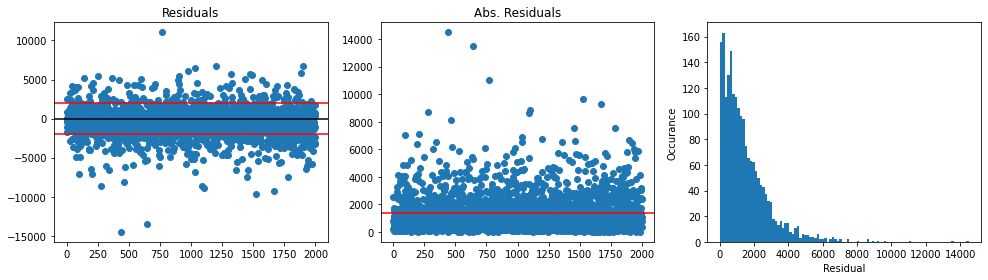

In [149]:
pred = model2.predict(codes_normed) * decode_range

res = (pred.flatten() - decode_sum)[:k]
std = np.std(res)

print("Abs. std: ", std);
print("Rel. std: ", std/decode_range);

fig, ax = plt.subplots(1,3, figsize=(14,4))

ax[0].plot(res, 'o');
ax[0].set_title('Residuals');
ax[0].axhline(0, c='k');
ax[0].axhline(std, c='red');
ax[0].axhline(-std, c='red');

res = np.abs((pred.flatten() - decode_sum)[:k])
std = np.std(res)

print("Abs. (abs) std: ", std);
print("Rel. (abs) std: ", std/decode_range);

ax[1].plot(res, 'o');
ax[1].set_title('Abs. Residuals');
ax[1].axhline(std, c='red');

ax[2].hist(res, bins=100);
ax[2].set_ylabel('Occurance');
ax[2].set_xlabel('Residual');

plt.tight_layout();

We can see that learning a network to regress the sum directly performs **much better** than if we train the two tasks sequentially. Furthermore, we see that the predictions seem to be even better than the noise in the data! This means that there must be some structure in the noise which the network does learn.

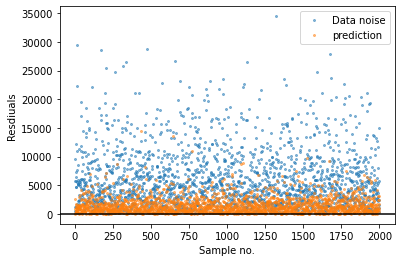

In [167]:
plt.plot((adc_sum - decode_sum)[:k], 'o', alpha=0.5, label='Data noise', markersize=2);
plt.plot(np.abs(pred.flatten() - decode_sum)[:k], 'o', alpha=0.5, label='prediction', markersize=2);

plt.axhline(0, c='k');
plt.ylabel('Resdiuals');
plt.xlabel('Sample no.');
plt.legend();

For the predictions of 0 the network predicts a constant -11. Considering the std of about 2000 this value is reasonably close to 0. 

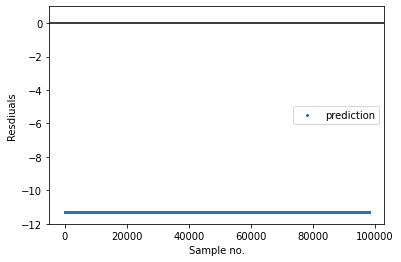

In [186]:
plt.plot((pred.flatten() - decode_sum)[k:], 'o', label='prediction', markersize=2);

plt.axhline(0, c='k');
plt.ylabel('Resdiuals');
plt.xlabel('Sample no.');
plt.ylim([-12,1])
plt.legend();

# Conclusions
* Pixel sum regression is an easy task which can be learned (mostly) perfectly in a *shallow* network in a short amount of time.
* If we add (random) noise to data the predictions after regression exhibits the same amount of noise as in the input.
* With enough time and training data a network can learn arbitrary maps (functions).
* Thus, **we can predict 4E3M encoded calorimeter data at the order (or even better than) the "noise" which the encoding introduced (plus the noise which is present in the raw data).**
* Lastly, training on decoding and regression together gives the best predictions.